In [1]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor

In [2]:
# Qiskit Classes
import qiskit.quantum_info as qi
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.compiler import assemble
from qiskit.circuit.library.standard_gates import HGate

# Tomography Functions
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.ignis.verification.tomography import process_tomography_circuits, ProcessTomographyFitter
from qiskit.ignis.verification.tomography import gateset_tomography_circuits, GatesetTomographyFitter
import qiskit.ignis.mitigation.measurement as mc


## Bell Tomo

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.70710678+0.j],
            dims=(2, 2))


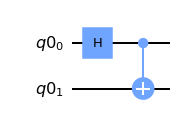

In [3]:
# Create the expected statevector
q2 = QuantumRegister(2)
bell = QuantumCircuit(q2)
bell.h(q2[0])
bell.cx(q2[0], q2[1])
bell.draw('mpl')

target_state_bell = qi.Statevector.from_instruction(bell)
print(target_state_bell)

In [4]:
# Generate the state tomography circuits.
qst_bell = state_tomography_circuits(bell, [q2[0], q2[1]])

# Execute
job = qiskit.execute(qst_bell, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter_bell = StateTomographyFitter(job.result(), qst_bell)

/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:468: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  prep += circuit
/opt/conda/lib/python3.8/site-packages/qiskit/circuit/quantumcircuit.py:876: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)
/opt/conda/lib/python3.8/site-packages/qiskit/ignis/verification/tomography/basis/circuits.py:478: DeprecationWarning: The QuantumCircuit.__add__() method is being deprecated.Use the compose() method which is more flexible w.r.t circuit register compatibility.
  circ = prep + meas
/opt/conda/lib/python3.8/site-packages/qiskit/circui

In [5]:
# Perform the tomography fit
# which outputs a density matrix
rho_fit_bell = tomo_fitter_bell.fit(method='lstsq')
F_bell = qi.state_fidelity(rho_fit_bell, target_state_bell)
print('State Fidelity: F = {:.5f}'.format(F_bell))

State Fidelity: F = 0.99396


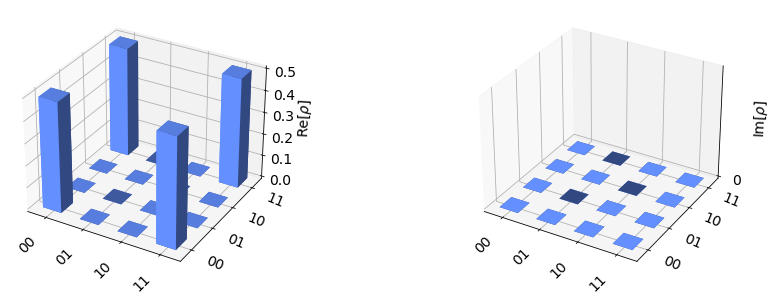

In [6]:
_ = plot_state_city(target_state_bell)

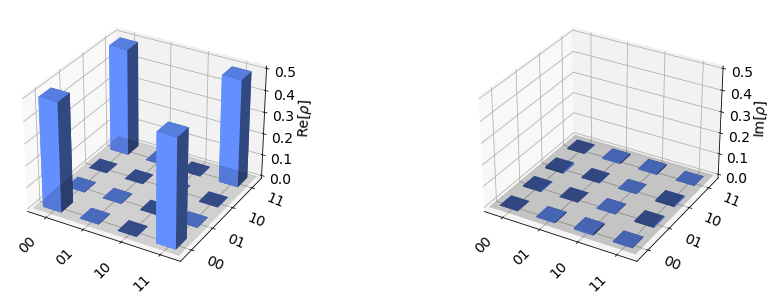

In [7]:
_ = plot_state_city(rho_fit_bell)

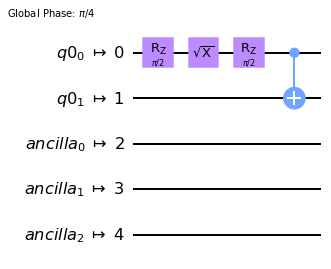

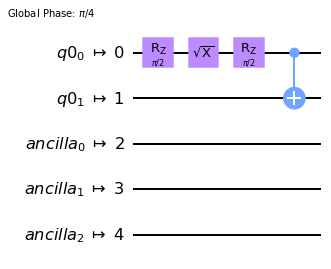

In [8]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(bell, backend, optimization_level=3)
t_qc.draw('mpl')

In [9]:

#Add measurement noise
noise_model = noise.NoiseModel.from_backend(backend)

#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1])

# backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job_tomo = qiskit.execute(qst_bell, backend=backend, shots=1024)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_bell = StateTomographyFitter(job_tomo.result(), qst_bell)

#no correction
rho_bell = tomo_bell.fit(method='lstsq')
F_bell = qi.state_fidelity(rho_bell, target_state_bell)
print('State fidelity (no correction): F = {:.5f}'.format(F_bell))

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_bell_mit = StateTomographyFitter(correct_tomo_results, qst_bell)
rho_fit_bell_mit = tomo_bell_mit.fit(method='lstsq')
F_bell_mit = qi.state_fidelity(rho_fit_bell_mit, target_state_bell)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_bell_mit))

State fidelity (no correction): F = 0.83859
State fidelity (w/ correction): F = 0.94309


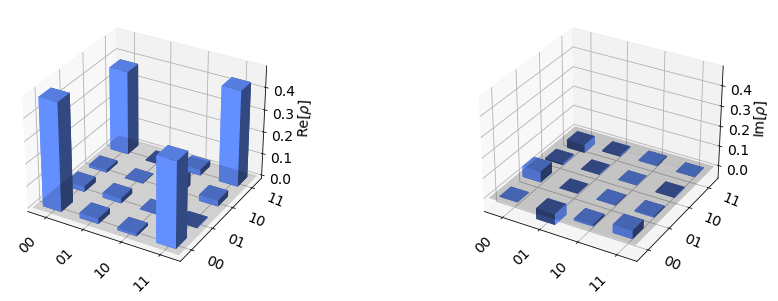

In [10]:
_ = plot_state_city(rho_bell)

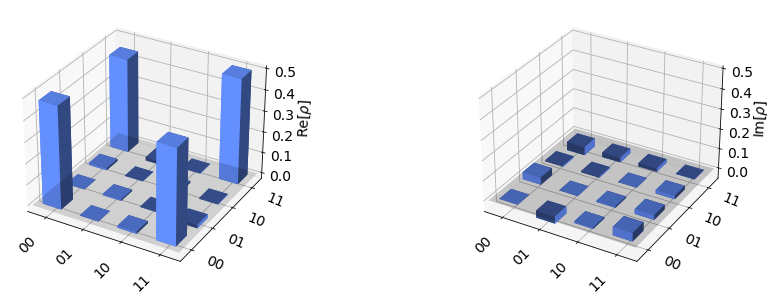

In [11]:
_ = plot_state_city(rho_fit_bell_mit)

## GHZ

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))


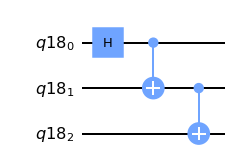

In [12]:
# Create the expected statevector
q2 = QuantumRegister(3)
ghz = QuantumCircuit(q2)
ghz.h(q2[0])
ghz.cx(q2[0], q2[1])
ghz.cx(q2[1], q2[2])
ghz.draw('mpl')

target_state_ghz = qi.Statevector.from_instruction(ghz)
print(target_state_ghz)

In [13]:
# Generate the state tomography circuits.
qst_ghz = state_tomography_circuits(ghz, [q2[0], q2[1], q2[2]])

# Execute
job = qiskit.execute(qst_ghz, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter_ghz = StateTomographyFitter(job.result(), qst_ghz)

# Perform the tomography fit
# which outputs a density matrix
rho_fit_ghz = tomo_fitter_ghz.fit(method='lstsq')
F_ghz = qi.state_fidelity(rho_fit_ghz, target_state_ghz)
print('State Fidelity: F = {:.5f}'.format(F_ghz))

State Fidelity: F = 0.99541


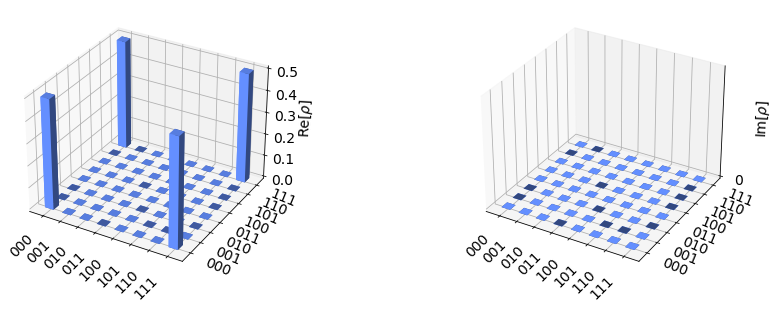

In [14]:
_ = plot_state_city(target_state_ghz)

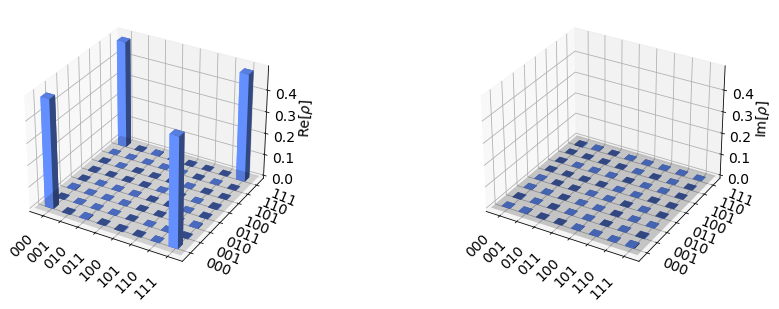

In [15]:
_ = plot_state_city(rho_fit_ghz)

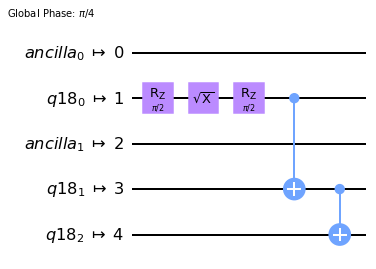

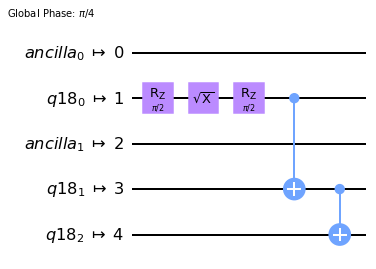

In [16]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(ghz, backend, optimization_level=3)
t_qc.draw('mpl')

In [17]:

#Add measurement noise
noise_model = noise.NoiseModel.from_backend(backend)

#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

# backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job_tomo = qiskit.execute(qst_ghz, backend=backend, shots=1024)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_ghz = StateTomographyFitter(job_tomo.result(), qst_ghz)

#no correction
rho_ghz = tomo_ghz.fit(method='lstsq')
F_ghz = qi.state_fidelity(rho_ghz, target_state_ghz)
print('State fidelity (no correction): F = {:.5f}'.format(F_ghz))

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_ghz_mit = StateTomographyFitter(correct_tomo_results, qst_ghz)
rho_fit_ghz_mit = tomo_ghz_mit.fit(method='lstsq')
F_ghz_mit = qi.state_fidelity(rho_fit_ghz_mit, target_state_ghz)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_ghz_mit))

State fidelity (no correction): F = 0.69282
State fidelity (w/ correction): F = 0.83442


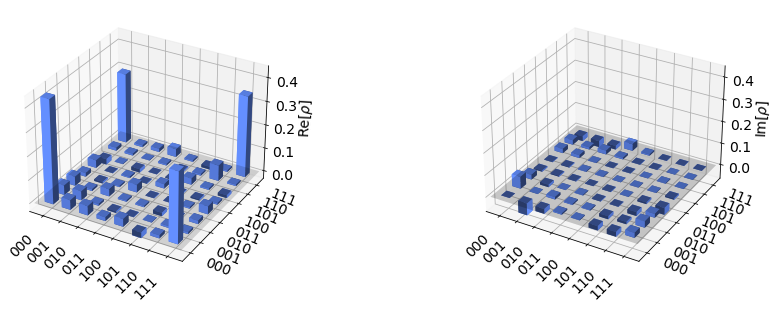

In [18]:
_ = plot_state_city(rho_ghz)

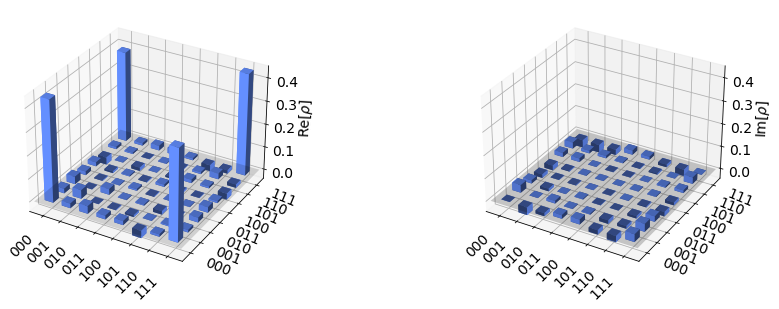

In [19]:
_ = plot_state_city(rho_fit_ghz_mit)

## W State

Statevector([0.        +0.j, 0.57735027+0.j, 0.57735027+0.j,
             0.        +0.j, 0.57735027+0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j],
            dims=(2, 2, 2))


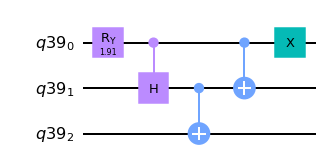

In [20]:
# Create the expected statevector
q2 = QuantumRegister(3)
w = QuantumCircuit(q2)
w.ry(2*np.arccos(1/np.sqrt(3)),q2[0])
ch = HGate().control(1)
w.append(ch,q2[0:2])
w.cx(q2[1],q2[2])
w.cx(q2[0],q2[1])
w.x(q2[0])
w.draw('mpl')

target_state_w = qi.Statevector.from_instruction(w)
print(target_state_w)

In [21]:
# Generate the state tomography circuits.
qst_w = state_tomography_circuits(w, [q2[0], q2[1], q2[2]])

# Execute
job = qiskit.execute(qst_w, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter_w = StateTomographyFitter(job.result(), qst_w)

# Perform the tomography fit
# which outputs a density matrix
rho_fit_w = tomo_fitter_w.fit(method='lstsq')
F_w = qi.state_fidelity(rho_fit_w, target_state_w)
print('State Fidelity: F = {:.5f}'.format(F_w))

State Fidelity: F = 0.99380


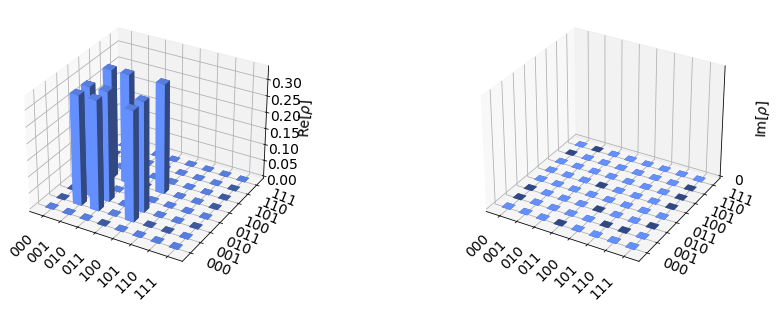

In [22]:
_ = plot_state_city(target_state_w)

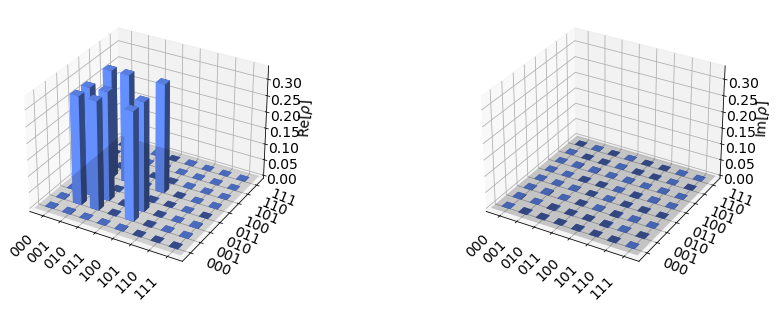

In [23]:
_ = plot_state_city(rho_fit_w)

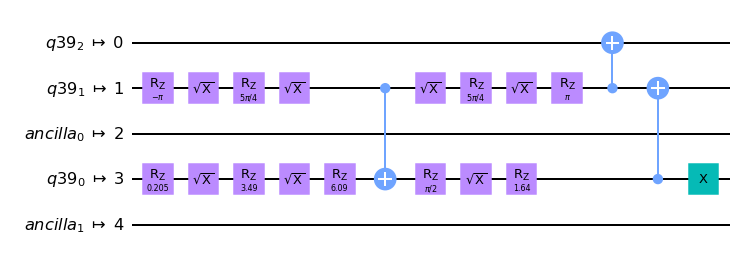

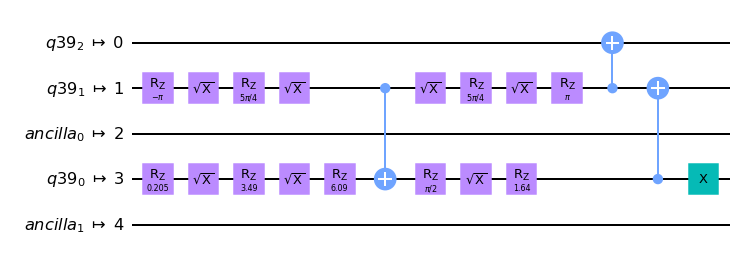

In [24]:
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(w, backend, optimization_level=3)
t_qc.draw('mpl')

In [25]:

#Add measurement noise
noise_model = noise.NoiseModel.from_backend(backend)

#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2])

# backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job_tomo = qiskit.execute(qst_w, backend=backend, shots=1024)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_w = StateTomographyFitter(job_tomo.result(), qst_w)

#no correction
rho_w = tomo_w.fit(method='lstsq')
F_w = qi.state_fidelity(rho_w, target_state_w)
print('State fidelity (no correction): F = {:.5f}'.format(F_w))

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_w_mit = StateTomographyFitter(correct_tomo_results, qst_w)
rho_fit_w_mit = tomo_w_mit.fit(method='lstsq')
F_w_mit = qi.state_fidelity(rho_fit_w_mit, target_state_w)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_w_mit))

State fidelity (no correction): F = 0.72176
State fidelity (w/ correction): F = 0.83045


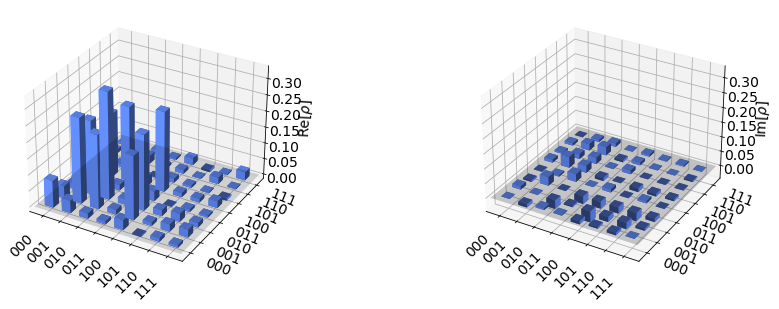

In [26]:
_ = plot_state_city(rho_w)

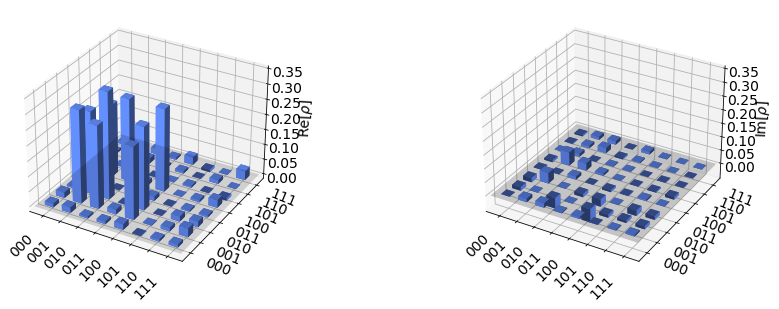

In [27]:
_ = plot_state_city(rho_fit_w_mit)

# Entanglement Swapping

Statevector([5.00000000e-01+0.j, 0.00000000e+00+0.j, 3.11164266e-19+0.j,
             0.00000000e+00+0.j, 0.00000000e+00+0.j, 5.00000000e-01+0.j,
             0.00000000e+00+0.j, 3.11164266e-19+0.j, 3.11164266e-19+0.j,
             0.00000000e+00+0.j, 5.00000000e-01+0.j, 0.00000000e+00+0.j,
             0.00000000e+00+0.j, 3.11164266e-19+0.j, 0.00000000e+00+0.j,
             5.00000000e-01+0.j],
            dims=(2, 2, 2, 2))


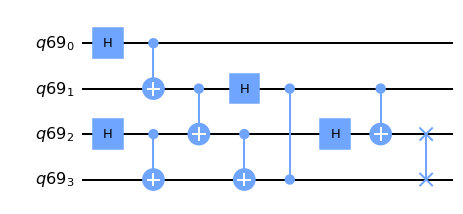

In [28]:
q2 = QuantumRegister(4)
swap = QuantumCircuit(q2)
swap.h(q2[0])
swap.cx(q2[0], q2[1])
swap.h(q2[2])
swap.cx(q2[2], q2[3])
swap.cx(q2[1],q2[2])
swap.h(q2[1])
swap.cx(q2[2], q2[3])
swap.cz(q2[1],q2[3])
swap.h(q2[2])
swap.cx(q2[1],q2[2])
swap.swap(q2[2],q2[3])
swap.draw('mpl')

target_state_swap = qi.Statevector.from_instruction(swap)
print(target_state_swap)

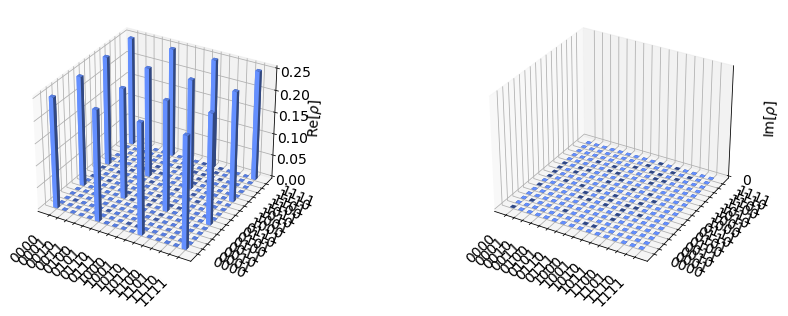

In [29]:
_ = plot_state_city(target_state_swap)

In [30]:
# Generate the state tomography circuits.
qst_swap = state_tomography_circuits(swap, [q2[0], q2[1], q2[2], q2[3]])

# Execute
job = qiskit.execute(qst_swap, Aer.get_backend('qasm_simulator'), shots=5000)

# Fit result
tomo_fitter_swap = StateTomographyFitter(job.result(), qst_swap)

# Perform the tomography fit
# which outputs a density matrix
rho_fit_swap = tomo_fitter_swap.fit(method='lstsq')
F_swap = qi.state_fidelity(rho_fit_swap, target_state_swap)
print('State Fidelity: F = {:.5f}'.format(F_swap))

State Fidelity: F = 0.99328


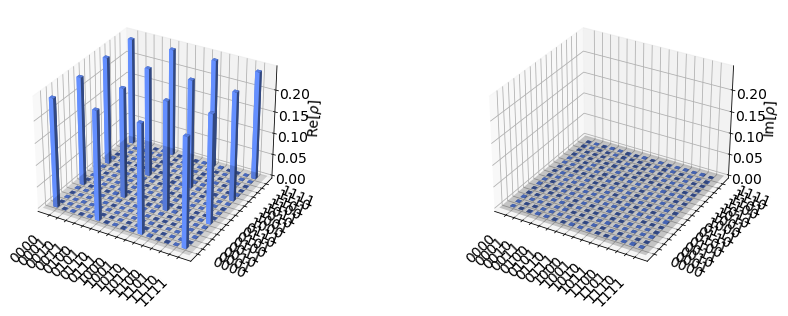

In [31]:
_ = plot_state_city(rho_fit_swap)

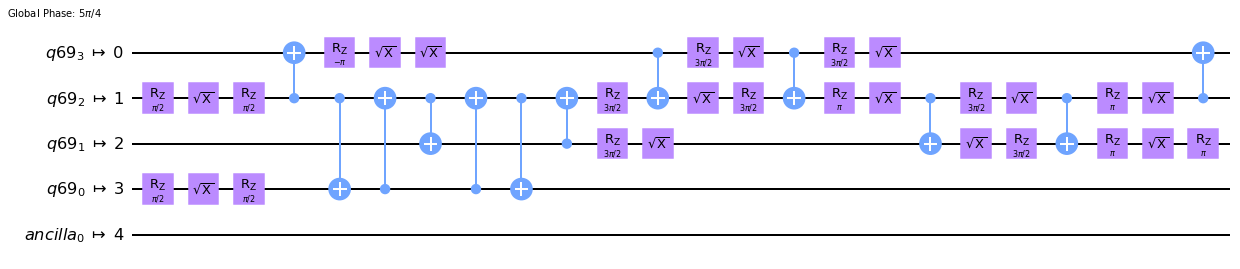

In [32]:
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 4 and
                                   not b.configuration().simulator and b.status().operational==True and b.configuration().max_experiments>=81))
t_qc = transpile(swap, backend, optimization_level=3)
_ = t_qc.draw('mpl')

In [33]:
len(qst_swap)

81

In [34]:
#Add measurement noise
noise_model = noise.NoiseModel.from_backend(backend)

#generate the calibration circuits
meas_calibs, state_labels = mc.complete_meas_cal(qubit_list=[0,1,2,3])

# backend = Aer.get_backend('qasm_simulator')
job_cal = qiskit.execute(meas_calibs, backend=backend, shots=1024)
job_tomo = qiskit.execute(qst_swap, backend=backend, shots=1024)

meas_fitter = mc.CompleteMeasFitter(job_cal.result(),state_labels)

tomo_swap = StateTomographyFitter(job_tomo.result(), qst_swap)

#no correction
rho_swap = tomo_swap.fit(method='lstsq')
F_swap = qi.state_fidelity(rho_swap, target_state_swap)
print('State fidelity (no correction): F = {:.5f}'.format(F_swap))

#correct data
correct_tomo_results = meas_fitter.filter.apply(job_tomo.result(), method='least_squares')
tomo_swap_mit = StateTomographyFitter(correct_tomo_results, qst_swap)
rho_fit_swap_mit = tomo_swap_mit.fit(method='lstsq')
F_swap_mit = qi.state_fidelity(rho_fit_swap_mit, target_state_swap)
print('State fidelity (w/ correction): F = {:.5f}'.format(F_swap_mit))

State fidelity (no correction): F = 0.39047
State fidelity (w/ correction): F = 0.44413


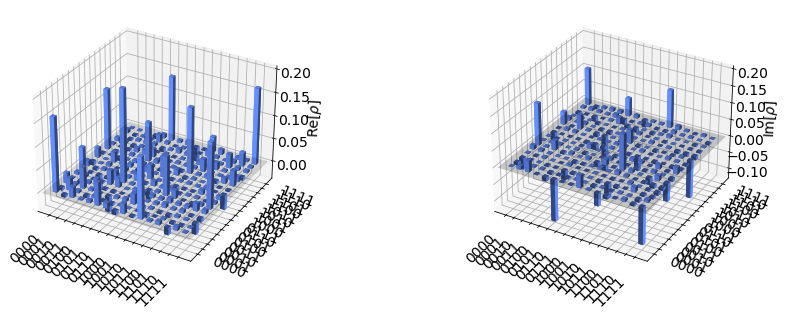

In [35]:
_ = plot_state_city(rho_swap)

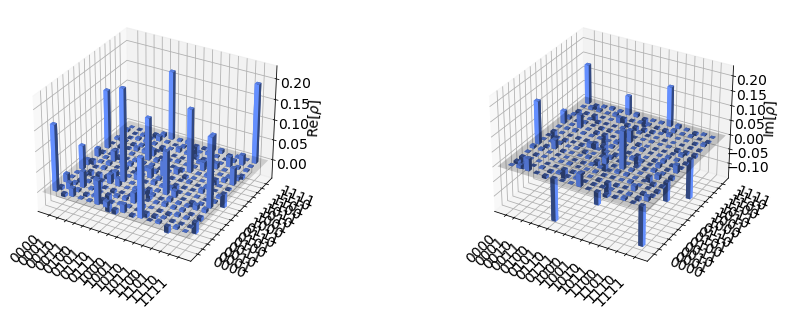

In [36]:
_ = plot_state_city(rho_fit_swap_mit)

{'1111': 250, '0101': 271, '1010': 246, '0000': 257}


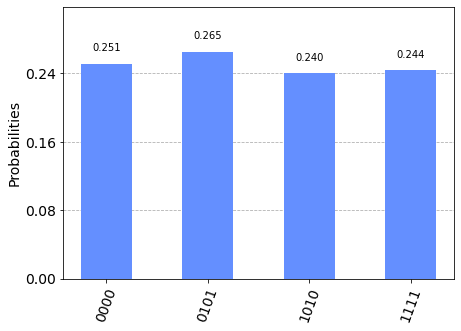

In [37]:
swap.measure_all()
aer_sim = Aer.get_backend('aer_simulator')
result = aer_sim.run(swap).result()
counts = result.get_counts(swap)
print(counts)
_ = plot_histogram(counts)